In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk

# CountVectorizer會計算單字出現在文件的次數；再透過TfidfVectorizer轉換成TFIDF和IDF
# 也可以直接使用TfidfTransformer計算TFIDF。
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_train

,class,tweet
0,1,"[9-1-13] 2:50 pm ""son of a bitch ate my mac n ..."
1,1,RT @BryceSerna: Don't be a pussy grab the boot...
2,2,RT @ClicquotSuave: bunch of rappers boutta flo...
3,2,@michigannews13 wow. Thats great language comi...
4,1,"and this is why I'm single, I don't fuck with ..."
...,...,...
14864,1,RT @Estellleeee: Lol bitches act hard when the...
14865,1,RT @yes_paul: I bitch about unnecessary things...
14866,1,"RT @Im_Amy_Bitches: I'm not always a bitch, so..."
14867,1,RT @dkiswinning: GamePlan: 1. Eat the pussy 2....


In [3]:
# Adding text-length as a field in the df_train
# apply 是一個在 pandas dataframe 加入新列（Column）的指令
df_train['text length'] = df_train['tweet'].apply(len)
df_train
# print(df_train.head())

,class,tweet,text length
0,1,"[9-1-13] 2:50 pm ""son of a bitch ate my mac n ...",76
1,1,RT @BryceSerna: Don't be a pussy grab the boot...,86
2,2,RT @ClicquotSuave: bunch of rappers boutta flo...,79
3,2,@michigannews13 wow. Thats great language comi...,129
4,1,"and this is why I'm single, I don't fuck with ...",77
...,...,...,...
14864,1,RT @Estellleeee: Lol bitches act hard when the...,102
14865,1,RT @yes_paul: I bitch about unnecessary things...,50
14866,1,"RT @Im_Amy_Bitches: I'm not always a bitch, so...",61
14867,1,RT @dkiswinning: GamePlan: 1. Eat the pussy 2....,131


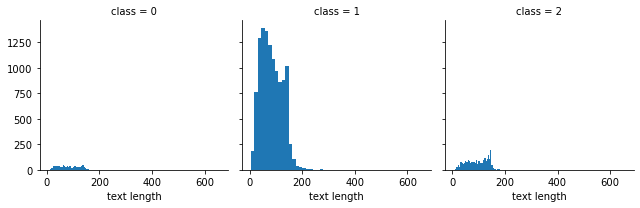

In [4]:
# Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
graph = sns.FacetGrid(data=df_train, col='class')
graph.map(plt.hist, 'text length', bins=50)

<AxesSubplot:xlabel='class', ylabel='text length'>

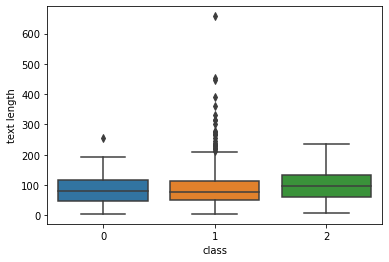

In [5]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=df_train)

<AxesSubplot:>

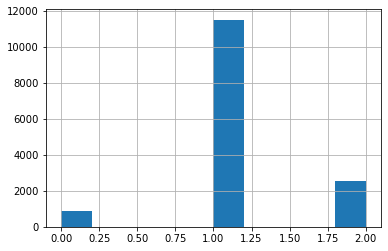

In [6]:
df_train['class'].hist()

In [7]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=df_train.tweet

In [8]:
# Preprocessing of the tweets
## 1. Removal of punctuation and capitalization
## 2. Tokenizing 斷詞
## 3. Removal of stopwords
## 4. Stemming 去除字尾

nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")
# stopwords

# extending the stopwords to include other words used in twitter such as retweet(rt) etc.
# retweet(rt)：轉發字詞
other_exclusions = ["#ff", "ff", "rt"]
# 擴充套件以附加單詞列表
stopwords.extend(other_exclusions)


def preprocess(tweet):  
    
    # removal of extra spaces
    # regular expression正則表達式
    # re+匹配1個或多個符合匹配符(\s空白符)
    # re.compile可以幫助我們編譯正則表達式，並生成一個pattern對象
    regex_pattern = re.compile(r'\s+') 
    tweet_space = tweet.str.replace(regex_pattern,' ')
    
    # removal of @name[mention]
    regex_pattern = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pattern,'')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex,'')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
#     newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # 初始化
    stemmer = PorterStemmer()
    # stemming of the tweets
    # [pm, son, bitch, ate, mac, n, chees]形式
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        # 將字符串、元組、列表中的元素以指定的字符(分隔符)連接生成一個新的字符串
        # ' '插入每個tokenized_tweet[i]之間
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

df_train['processed_tweets'] = processed_tweets
print(df_train[["processed_tweets"]])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        processed_tweets
0                           pm son bitch ate mac n chees
1              pussi grab booti love booti appreci booti
2       bunch rapper boutta flood internet w trash remix
3      wow that great languag come hs coach sure role...
4                           singl fuck bitch attitud foh
...                                                  ...
14864               lol bitch act hard stay get ass beat
14865                        bitch unnecessari thing lol
14866                          alway bitch sometim sleep
14867  gameplan eat pussi beat pussi apolog pussi eat...
14868       know boyfriend saturday night lol fuck bitch

[14869 rows x 1 columns]


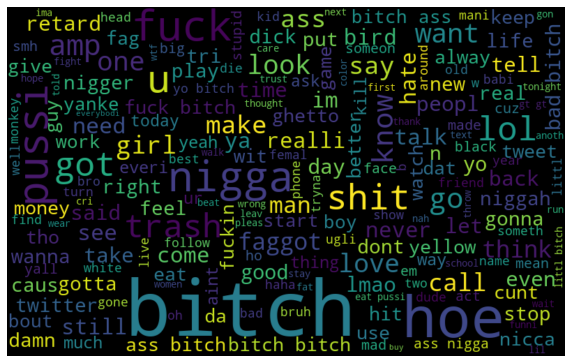

In [9]:
# visualizing which of the word is most commonly used in the twitter df_train
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in df_train['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

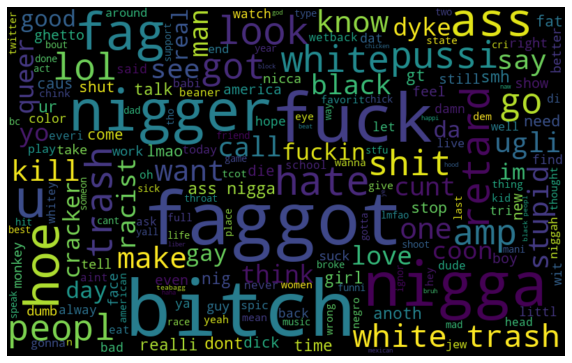

In [10]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in df_train['processed_tweets'][df_train['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

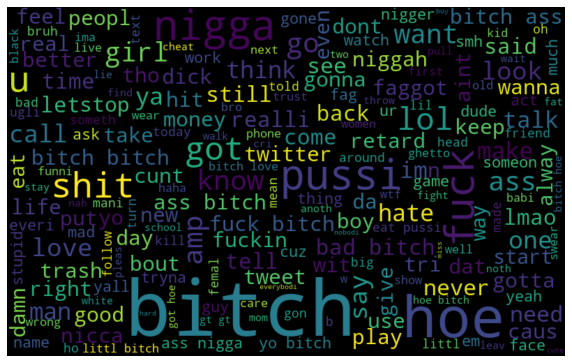

In [11]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in df_train['processed_tweets'][df_train['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [12]:
# TF(特定單字在文件出現次數/文件總次數)
# IDF 
# 將文字轉換為向量的方式，TF和IDF相乘：TFxIDF，得到的綜合分數就是TFIDF。
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df_train['processed_tweets'] )

df_tfidf= pd.DataFrame(tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names())
df_tfidf

,ab,abil,abl,abo,abort,absolut,abt,abus,accept,accid,...,young thug,your,yr,yr old,yu,yung,yup,zebra,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test df_trains would have different values each time.
X = tfidf
y = df_train['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_tfidf,y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
#get testing data
df_test=pd.read_csv('test.csv')
# df_test=preprocess(df_test)
#test_tweet=df_test.tweet
processed_test_tweets = preprocess(df_test.tweet)   
df_test['processed_test_tweets'] = processed_test_tweets
print(df_test[["processed_test_tweets"]])
# df_test=pd.df_test
# prediction = model.predict(df_test)
# output=df_test['id']
# output=pd.DataFrame(output)
# output

                                  processed_test_tweets
0            dawg ever fuck bitch start cri confus shit
1                                      look like tranni
2                 sit hate anoth bitch got much shit go
3               caus tire big bitch come us skinni girl
4                       hobbi includ fight mariam bitch
...                                                 ...
9909                                             nigger
9910  muthaf lie right tl trash mine bibl scriptur hymn
9911  young buck wanna eat dat nigguh like aint fuck...
9912                     youu got wild bitch tellin lie
9913  ruffl ntac eileen dahlia beauti color combin p...

[9914 rows x 1 columns]


In [18]:
df_test

,id,tweet,processed_test_tweets
0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
2,2,"!!!!!!""@__BrighterDays: I can not just sit up ...",sit hate anoth bitch got much shit go
3,3,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,caus tire big bitch come us skinni girl
4,4,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbi includ fight mariam bitch
...,...,...,...
9909,9909,you're all niggers,nigger
9910,9910,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf lie right tl trash mine bibl scriptur hymn
9911,9911,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
9912,9912,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


In [19]:
#X_test_tfidf = pd.DataFrame(X_test_tfidf)
#X_train_tfidf = pd.DataFrame(X_train_tfidf)
#y_train = pd.DataFrame(y_train)
#y_test = pd.DataFrame(y_test)

In [20]:
test_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
test_tfidf = test_tfidf_vectorizer.fit_transform(df_test['processed_test_tweets'] )

df_test_tfidf= pd.DataFrame(test_tfidf.toarray(),columns=test_tfidf_vectorizer.get_feature_names())
df_test_tfidf

,abo,absolut,abus,accept,accid,accident,account,across,act,act like,...,young,your,youtub,yr,yu,yung,zebra,zero,zimmerman,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.318339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
